In [2]:
# Imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, AvgPool2D, Layer, Add
from tensorflow.keras import optimizers
import tensorflow as tf

import numpy as np

from tqdm import tqdm
import requests
import os

In [3]:
dataset = "./data/mnist_test_seq.npy"

if not os.path.exists('./data'):
    os.mkdir('./data')
    
# Download data
if not os.path.exists(dataset):
    r = requests.get("http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy")
    open(dataset, 'wb').write(r.content)


In [4]:
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

def plot_sequence_images(image_array):
    dpi = 72.0
    xpixels, ypixels = image_array[0].shape[:2]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        if image_array[i].shape[-1] == 1:
            image = image_array[i][:,:,0]
        else:
            image = image_array[i]
        im.set_array(image)
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array), interval=33, repeat_delay=1, repeat=True)
    display(HTML(anim.to_html5_video()))

In [5]:
# Load the Data

assert os.path.exists(dataset), "ASSERT ERROR: The file does not exist."
data = np.float32(np.load(dataset) / 255.0)
data_samples = data.shape[0]

data_frames  = data.shape[1]
data = np.swapaxes(data, 0, 1)
data = np.expand_dims(data, -1)

In [6]:
plot_sequence_images(data[0])

<Figure size 64x64 with 0 Axes>

In [7]:
display(data_samples, data_frames)
display(data.shape)

20

10000

(10000, 20, 64, 64, 1)

In [8]:
class ConvTTLSTMLayer(Layer):
    def __init__(self, input_channels, hidden_channels,
                      order=3, steps=3, ranks=8,
                      kernel_size=(5, 5), bias=True):
        super(ConvTTLSTMLayer, self).__init__()
        
        ## Input/output interfaces
        self.input_channels  = input_channels
        self.hidden_channels = hidden_channels
        
        # Number of hidden states taken
        self.steps = steps
        # Number of G matrices
        self.order = order
        # How many hiddent step by group to be preprocessed together
        self.lags = steps - order + 1
        
        ## Convolutional operations
        padding     = kernel_size[0] // 2, kernel_size[1] // 2
        
        # Change to 3D ? Same effecct but different optimisations
        preprocessing_Conv2D = lambda out_channels:  Conv2D(out_channels,
                                                            kernel_size=kernel_size,
                                                            padding=padding + (0,),
                                                            use_bias=bias)
    
        tt_Conv2D = lambda out_channels:  Conv2D(out_channels,
                                                  kernel_size=kernel_size,
                                                  padding=padding,
                                                  use_bias=bias)

        self.layers_preprocess = []
        self.layers_conv2d = []
        
        for l in range(order):
            self.layers_preprocess.append(preprocessing_Conv2D( 
                out_channels = ranks if l < order - 1 else 4 * hidden_channels))
            
            self.layers_conv2d.append(tt_Conv2D(out_channels = ranks))
        
        def initialize(self, inputs):
            '''
            Initialize the hidden cell states H
            '''
            
            batch_size, input_channels, height, width = inputs.size()
            
            self.hidden_states = [tf.zeros([batch_size, 
                height, width, self.hidden_channels])] * self.steps
            self.hidden_state_index = 0
            self.cell_states = tf.zeros([batch_size,
                height, width, self.hidden_channels])
        
        def call(self, inputs, first_step = False):
            '''
            Call the model
            '''
            if first_step:
                self.initialize(inputs)
                first_step = False
            
            ## Preprocessing + Convolutional tensor-train module
            ## Algorithm 2
            for i in range(self.order):
                input_pointer = self.hidden_state_index if not i else (input_pointer + 1) % self.steps
                
                # Start hidden states input at pointer but wrap around
                input_states = self.hidden_states[input_pointer:] + self.hidden_states[:input_pointer]
                
                # Take one group of Hidden States
                input_states = input_states[:self.lags]
                
                input_states = tf.stack(input_states, dim=-1)
                input_states = self.layers_preprocess[l](input_states)
                
                if i == 0:
                    temp_states = input_states
                else: # if i > 0
                    temp_states = input_states + self.layers_conv2d[l - 1](temp_states)
                
            ## Standard convolutional-LSTM module
            concat_conv = self.layers_conv2d(tf.concat([inputs, temps_states], dim=-1))
            cc_i, cc_f, cc_o, cc_g = tf.split(concat_conv, self.hidden_channels, dim = -1)
            
            
            i = tf.math.sigmoid(cc_i)
            f = tf.math.sigmoid(cc_f)
            o = tf.math.sigmoid(cc_o)
            g = tf.math.tanh(cc_g)
            
            self.cell_states = f * self.cell_states + i * g
            outputs = o * torch.tanh(self.cell_states)
            self.hidden_states[self.hidden_state_index] = outputs
            self.hidden_pointer = (self.hidden_state_index + 1) % self.steps

            return outputs

In [9]:
input_shape = (28, 28, 1)
convttlstm = ConvTTLSTMLayer(5,3)
convttlstm.build((None, *input_shape))

In [10]:
class ConvTTLSTMNet(Model):
    def __init__(self,
                 input_channels,
                 layers_per_block:list, hidden_channels:list, skip_stride = None,
                 # Params for the TTLSTM
                 order=3, steps=3, ranks=8,
                 kernel_size = (3,3), bias = True,
                 output_sigmoid = False,
                 # Calling parameters
                 
                ):
        super(ConvTTLSTMNet, self).__init__()
        
        ## Hyperparameters
        self.layers_per_block = layers_per_block
        self.hidden_channels  = hidden_channels

        self.num_blocks = len(layers_per_block)
        assert self.num_blocks == len(hidden_channels), "Invalid number of blocks."
        
        
        self.skip_stride = (self.num_blocks + 1) if skip_stride is None else skip_stride

        self.output_sigmoid = output_sigmoid
        
        self.layers_ = {}
        
        # Model Architecture
        for b in range(self.num_blocks):
            for l in range(layers_per_block[b]):
                # number of input channels to the current layer
                if l > 0:
                    channels = hidden_channels[b]
                elif b == 0:
                    channels = input_channels
                else:
                    # First layer of a block after the first one
                    channels = hidden_channels[b - 1]
                
                # We keep the layer id for skip connections
                # FIXME ? Maybe there's something to do that with Keras ? Unsure
                lid = "b{}l{}".format(b, l)
                
                cttlstmlayer = ConvTTLSTMLayer(
                    input_channels = channels, hidden_channels = hidden_channels[b],
                    order = order, steps = steps, ranks = ranks, 
                    kernel_size = kernel_size, bias = bias)
                
                self.layers_[lid] = cttlstmlayer
                
        # Last Layer
        # nb of input
        channels = hidden_channels[-1]
        
        # ???????
        # Si il y a plus de blocks que la distance de skip, alots on ajoute à l'input
        # le skip ? FIXME ==> Essayez de comprendre
        if self.num_blocks >= self.skip_stride:
            channels += hidden_channels[-1-self.skip_stride]
            
        if self.output_sigmoid:
            activation="sigmoid"
        else:
            activation=None
            
        self.layers_["output"] = Conv2D(input_channels, kernel_size=(1,1), 
                                       activation=activation, padding="same", use_bias=True)
        
        
    def call(self, inputs, input_frames:int, future_frames:int, output_frames:int,
                teacher_forcing = False, scheduled_sampling_ratio = 0):
            # tf is teacher forcing ?
        if teacher_forcing and scheduled_sampling_ratio > 1e-6:
            teacher_forcing_mask = np.random.binomial(size=(inputs.size(0), future_frames - 1, 1, 1, 1), n=1, p=scheduled_sampling_ratio)
        else:
            teacher_forcing = False
            
        total_steps = input_frames + future_frames - 1
        outputs = [None] * total_steps

        for t in range(total_steps):
            if t < input_frames: 
                input_ = inputs[:, t]
            elif not teacher_forcing:
                input_ = outputs[t-1]
            else: # if t >= input_frames and teacher_forcing:
                mask = teacher_forcing_mask[:, t - input_frames]
                input_ = inputs[:, t] * mask + outputs[t-1] * (1 - mask)

            #print(input_.shape)
            first_step = (t == 0)

            queue = []

            for b in range(self.num_blocks):
                for l in range(self.layers_per_block[b]):
                    lid = "b{}l{}".format(b, l)
                    input_ = self.layers_[lid](input_, first_step = first_step)

                queue.append(input_)
                if b >= self.skip_stride:
                    input_ = tf.concat([input_, queue.pop(0)], dim=1)


            
            outputs[t] = self.layers_["output"](input_)

        outputs = outputs[-output_frames:]

        outputs = tf.stack([outputs[t] for t in range(output_frames)], axis = 1)

        return outputs

In [11]:
image_channels = 1
batch_size = 50
predict_frames = 50
input_shape = (batch_size, 20, 1, 64, 64)
batch = data[:batch_size]
convttlstm = ConvTTLSTMNet(1, [3,3,3,3], [32,48,48,32])
outputs = convttlstm.call(batch, 20, predict_frames, predict_frames)

In [12]:
outputs.shape

TensorShape([50, 50, 64, 64, 1])

In [13]:
plot_sequence_images(outputs[0])

<Figure size 64x64 with 0 Axes>

In [14]:
# Model parameters and hyper-parameters
num_training_iterations = 2000 
batch_size = 10
learning_rate = 1e-3 
seq_len = 5

# Checkpoint location: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")

In [20]:
# Optimizer and Loss function 
# Loss is based on the paper

def compute_loss(y_pred, y_true):
    loss = tf.keras.losses.MSE(y_true, y_pred)
    return loss

optimizer = tf.keras.optimizers.Adam(learning_rate)

In [16]:
batch = data[:batch_size]
convttlstm = ConvTTLSTMNet(1, [3,3,3,3], [32,48,48,32])

In [ ]:
# Generate train/test/validate set
# TODO

In [18]:
# Generate a random batch

def make_batch(data, seq_len = 5, batch_size=350):
    inputs = []
    outputs = []
    random_indexes = np.random.choice(data.shape[0], batch_size)
    for j in random_indexes:
        inputs += [data[j, i:i + seq_len] for i in range(data.shape[1] - seq_len)]
        outputs += [data[j, i:i + seq_len] for i in range(1, data.shape[1] - seq_len + 1)]
        
    inputs = np.array(inputs)
    outputs = np.array(outputs)    
    
    return inputs, outputs

batch_input, batch_output = make_batch(data)
display(batch_input.shape, batch_output.shape)

(5250, 5, 64, 64, 1)

(5250, 5, 64, 64, 1)

  0%|          | 2/2000 [00:16<4:37:13,  8.32s/it]


KeyboardInterrupt: 

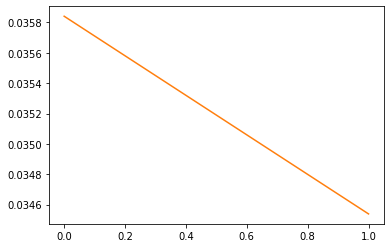

In [24]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:

        y_pred = convttlstm(x, input_frames=seq_len, future_frames=1, output_frames=seq_len)
        loss = compute_loss(y, y_pred)
        grads = tape.gradient(loss, convttlstm.trainable_variables)

        optimizer.apply_gradients(zip(grads, convttlstm.trainable_variables))
    return loss

history = []

for iter in tqdm(range(num_training_iterations)):
    x_batch, y_batch =  make_batch(data, seq_len)
    loss = train_step(x_batch, y_batch)

    history.append(loss.numpy().mean())
    plt.plot(history)

    if iter % 100 == 0:
        convttlstm.save_weights(checkpoint_prefix)
    
convttlstm.save_weights(checkpoint_prefix)